(marginalizing-models)=
# Automatic marginalization of discrete variables

:::{post} Jan 20, 2024
:tags: mixture model
:category: intermediate, how-to
:author: Rob Zinkov
:::

PyMC is very amendable to sampling models with discrete latent variables. But if you insist on using the NUTS sampler exclusively, you will need to get rid of your discrete variables somehow. The best way to do this is by marginalizing them out, as then you benefit from Rao-Blackwell's theorem and get a lower variance estimate of your parameters.

Formally the argument goes like this, samplers can be understood as approximating the expectation $\mathbb{E}_{p(x, z)}[f(x, z)]$ for some function $f$ with respect to a distribution $p(x, z)$. By [law of total expectation](https://en.wikipedia.org/wiki/Law_of_total_expectation) we know that

$$ \mathbb{E}_{p(x, z)}[f(x, z)] =  \mathbb{E}_{p(z)}\left[\mathbb{E}_{p(x \mid z)}\left[f(x, z)\right]\right] $$

Letting $g(z) = \mathbb{E}_{p(x \mid z)}\left[f(x, z)\right]$, we know by [law of total variance](https://en.wikipedia.org/wiki/Law_of_total_variance) that

$$ \mathbb{V}_{p(x, z)}[f(x, z)] = \mathbb{V}_{p(z)}[g(z)] + \mathbb{E}_{p(z)}\left[\mathbb{V}_{p(x \mid z)}\left[f(x, z)\right]\right] $$

Because the expectation is over a variance it must always be positive, and thus we know

$$ \mathbb{V}_{p(x, z)}[f(x, z)] \geq \mathbb{V}_{p(z)}[g(z)] $$

Intuitively, marginalizing variables in your model lets you use $g$ instead of $f$. This lower variance manifests most directly in lower Monte-Carlo standard error (mcse), and indirectly in a generally higher effective sample size (ESS).

Unfortunately, the computation to do this is often tedious and unintuitive. Luckily, `pymc-experimental` now supports a way to do this work automatically!

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

:::{include} ../extra_installs.md
:::

In [2]:
import pymc_extras as pmx

In [3]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(32)

As a motivating example, consider a gaussian mixture model

## Gaussian Mixture model

There are two ways to specify the same model. One where the choice of mixture is explicit.

In [4]:
mu = pt.as_tensor([-2.0, 2.0])

with pmx.MarginalModel() as explicit_mixture:
    idx = pm.Bernoulli("idx", 0.7)
    y = pm.Normal("y", mu=mu[idx], sigma=1.0)

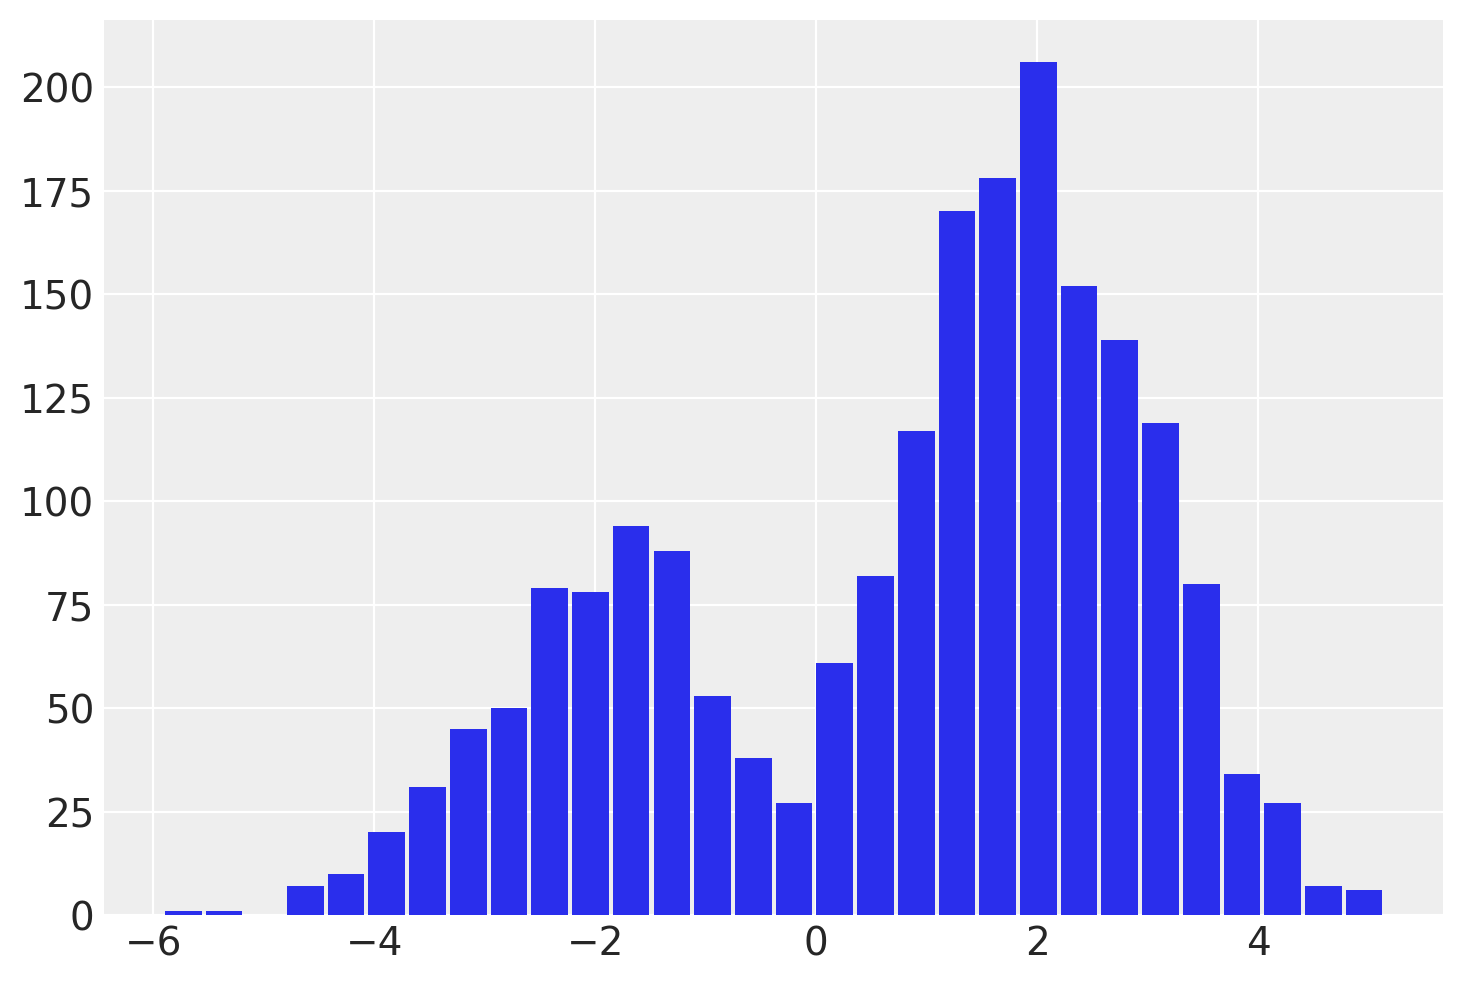

In [5]:
plt.hist(pm.draw(y, draws=2000, random_seed=rng), bins=30, rwidth=0.9);

The other way is where we use the built-in {class}`NormalMixture <pymc.NormalMixture>` distribution. Here the mixture assignment is not an explicit variable in our model. There is nothing unique about the first model other than we initialize it with {class}`pmx.MarginalModel <pymc_extras.MarginalModel>` instead of {class}`pm.Model <pymc.model.core.Model>`. This different class is what will allow us to marginalize out variables later.

In [6]:
with pm.Model() as prebuilt_mixture:
    y = pm.NormalMixture("y", w=[0.3, 0.7], mu=[-2, 2])

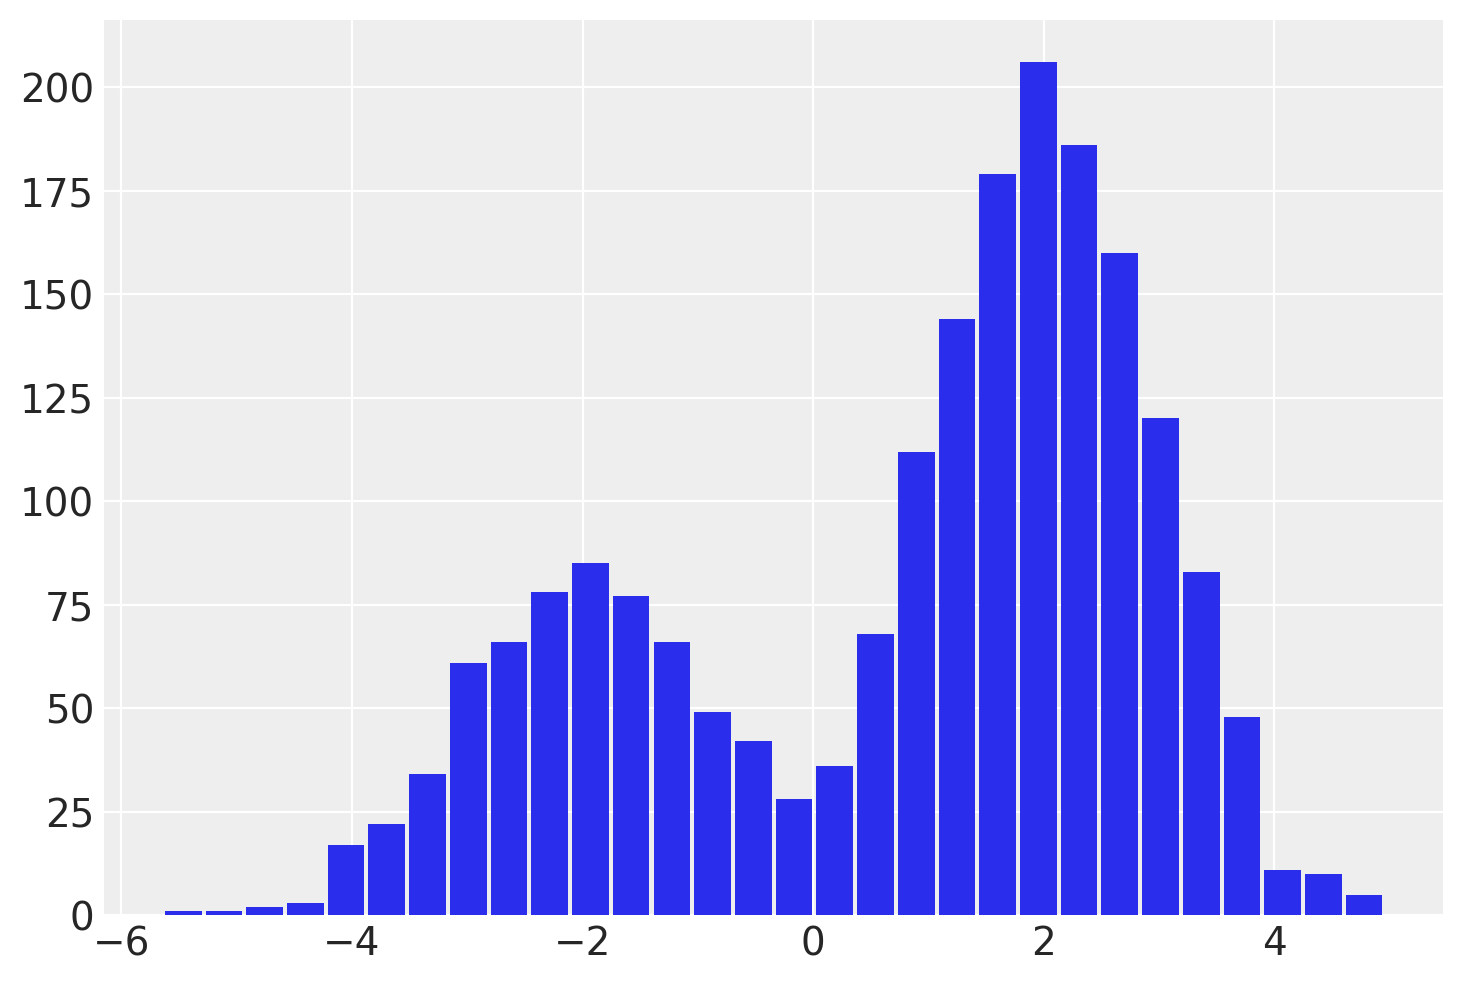

In [7]:
plt.hist(pm.draw(y, draws=2000, random_seed=rng), bins=30, rwidth=0.9);

In [8]:
with prebuilt_mixture:
    idata = pm.sample(draws=2000, chains=4, random_seed=rng)

az.summary(idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y,0.775,2.088,-3.117,3.85,0.092,0.065,664.0,1956.0,1.0


In [9]:
with explicit_mixture:
    idata = pm.sample(draws=2000, chains=4, random_seed=rng)

az.summary(idata)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [idx]
>NUTS: [y]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
idx,0.658,0.475,0.000,1.000,0.028,0.020,292.0,292.0,1.01
y,0.633,2.144,-3.297,3.678,0.117,0.083,433.0,2054.0,1.01


We can immediately see that the marginalized model has a higher ESS. Let's now marginalize out the choice and see what it changes in our model.

In [10]:
explicit_mixture.marginalize(["idx"])
with explicit_mixture:
    idata = pm.sample(draws=2000, chains=4, random_seed=rng)

az.summary(idata)

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y,0.787,2.095,-3.176,3.843,0.085,0.06,780.0,2274.0,1.01


As we can see, the `idx` variable is gone now. We also were able to use the NUTS sampler, and the ESS has improved.

But {class}`MarginalModel <pymc_extras.MarginalModel>` has a distinct advantage. It still knows about the discrete variables that were marginalized out, and we can obtain estimates for the posterior of `idx` given the other variables. We do this using the {meth}`recover_marginals <pymc_extras.MarginalModel.recover_marginals>` method.

In [11]:
explicit_mixture.recover_marginals(idata, random_seed=rng);

In [12]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y,0.787,2.095,-3.176,3.843,0.085,0.060,780.0,2274.0,1.01
idx,0.700,0.458,0.000,1.000,0.019,0.014,576.0,576.0,1.01
lp_idx[0],-6.214,5.195,-14.360,-0.000,0.192,0.136,780.0,2274.0,1.01
lp_idx[1],-2.219,3.969,-10.623,-0.000,0.157,0.111,780.0,2274.0,1.01


This `idx` variable lets us recover the mixture assignment variable after running the NUTS sampler! We can split out the samples of `y` by reading off the mixture label from the associated `idx` for each sample.

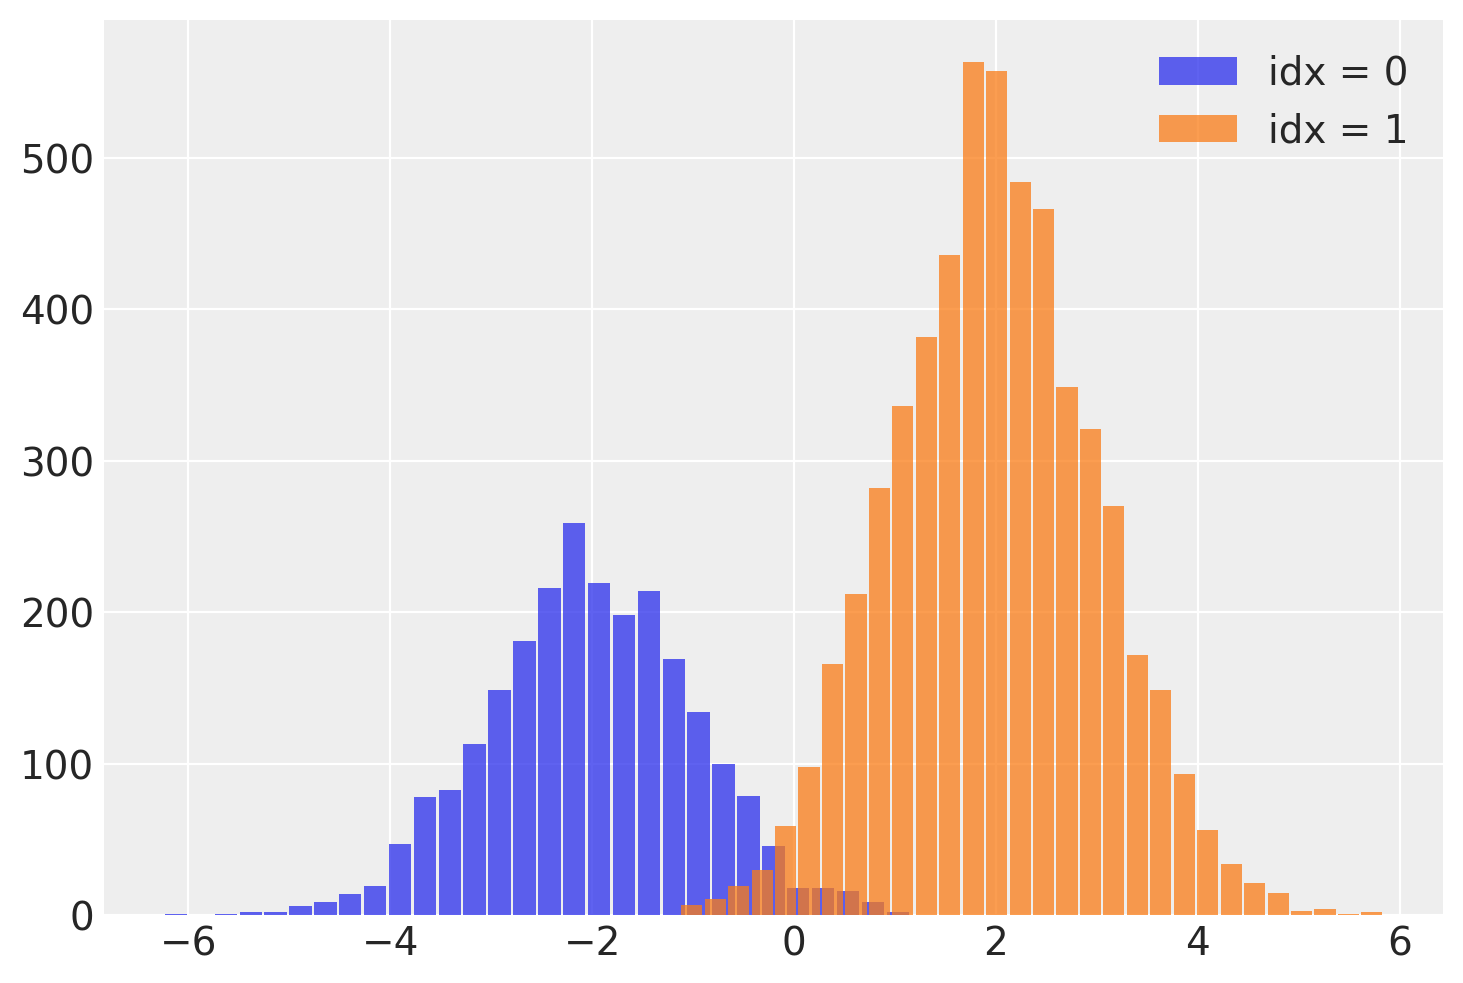

In [13]:
# fmt: off
post = idata.posterior
plt.hist(
    post.where(post.idx == 0).y.values.reshape(-1),
    bins=30,
    rwidth=0.9,
    alpha=0.75,
    label='idx = 0',
)
plt.hist(
    post.where(post.idx == 1).y.values.reshape(-1),
    bins=30,
    rwidth=0.9,
    alpha=0.75,
    label='idx = 1'
)
# fmt: on
plt.legend();

One important thing to notice is that this discrete variable has a lower ESS, and particularly so for the tail. This means `idx` might not be estimated well particularly for the tails. If this is important, I recommend using the `lp_idx` instead, which is the log-probability of `idx` given sample values on each iteration. The benefits of working with `lp_idx` will explored further in the next example.

## Coal mining model

The same methods work for the {ref}`Coal mining <pymc:pymc_overview#case-study-2-coal-mining-disasters>` switchpoint model as well. The coal mining dataset records the number of coal mining disasters in the UK between 1851 and 1962. The time series dataset captures a time when mining safety regulations are being introduced, we try to estimate when this occurred using a discrete `switchpoint` variable.

In [14]:
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)

# fmt: on
years = np.arange(1851, 1962)

with pmx.MarginalModel() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())
    early_rate = pm.Exponential("early_rate", 1.0, initval=3)
    late_rate = pm.Exponential("late_rate", 1.0, initval=1)
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/model/core.py:1288: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


We will sample the model both before and after we marginalize out the `switchpoint` variable

In [15]:
with disaster_model:
    before_marg = pm.sample(chains=2, random_seed=rng)

disaster_model.marginalize(["switchpoint"])

with disaster_model:
    after_marg = pm.sample(chains=2, random_seed=rng)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_unobserved]
>NUTS: [early_rate, late_rate]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/home/fonnesbeck/repos/pymc-examples/.pixi/envs/default/lib/python3.12/site-packages/pymc_extras/model/marginal/marginal_model.py:174: UserWarning: There are multiple dependent variables in a FiniteDiscreteMarginalRV. Their joint logp terms will be assigned to the first RV: disasters_unobserved
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [early_rate, late_rate]
>Metropolis: [disasters_unobserved]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [16]:
az.summary(before_marg, var_names=["~disasters"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
early_rate,3.100,0.289,2.547,3.620,0.008,0.005,1437.0,1294.0,1.00
late_rate,0.940,0.115,0.713,1.143,0.003,0.002,1294.0,1148.0,1.00
switchpoint,1889.406,2.387,1885.000,1893.000,0.214,0.151,127.0,334.0,1.02


In [17]:
az.summary(after_marg, var_names=["~disasters"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
early_rate,3.098,0.291,2.539,3.603,0.007,0.005,1796.0,1532.0,1.0
late_rate,0.930,0.121,0.704,1.152,0.003,0.002,1578.0,1433.0,1.0


As before, the ESS improved massively

Finally, let us recover the `switchpoint` variable

In [18]:
disaster_model.recover_marginals(after_marg);

In [19]:
az.summary(after_marg, var_names=["~disasters", "~lp"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
early_rate,3.098,0.291,2.539,3.603,0.007,0.005,1796.0,1532.0,1.0
late_rate,0.930,0.121,0.704,1.152,0.003,0.002,1578.0,1433.0,1.0
switchpoint,1889.692,2.444,1885.000,1893.000,0.076,0.054,965.0,1637.0,1.0


While `recover_marginals` is able to sample the discrete variables that were marginalized out. The probabilities associated with each draw often offer a cleaner estimate of the discrete variable. Particularly for lower probability values. This is best illustrated by comparing the histogram of the sampled values with the plot of the log-probabilities.

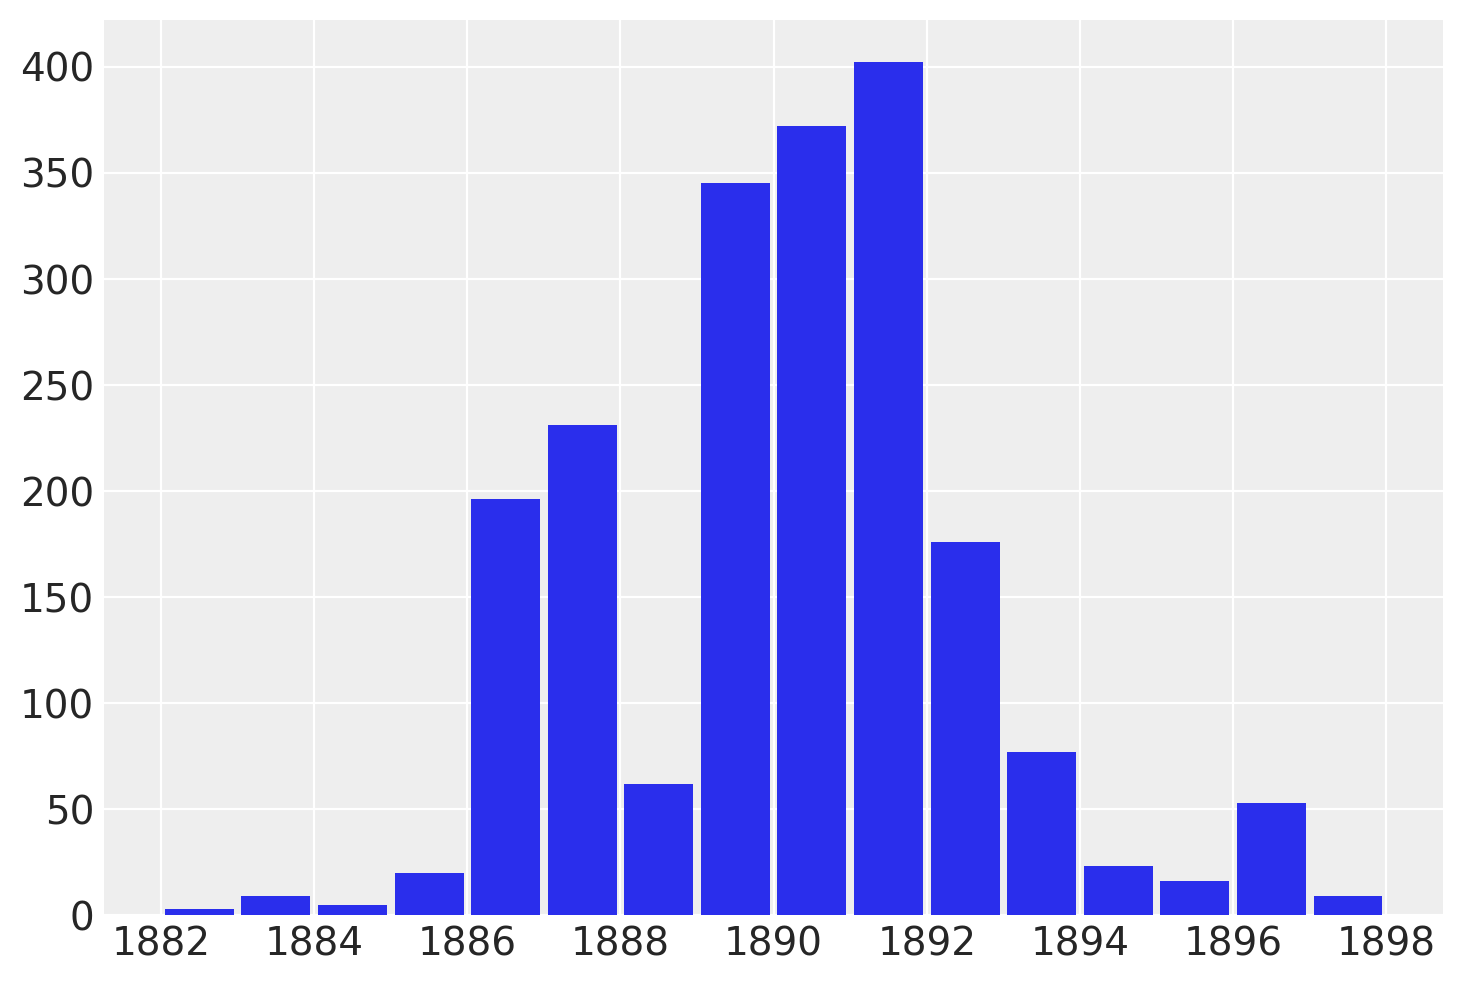

In [20]:
post = after_marg.posterior.switchpoint.values.reshape(-1)
bins = np.arange(post.min(), post.max())
plt.hist(post, bins, rwidth=0.9);

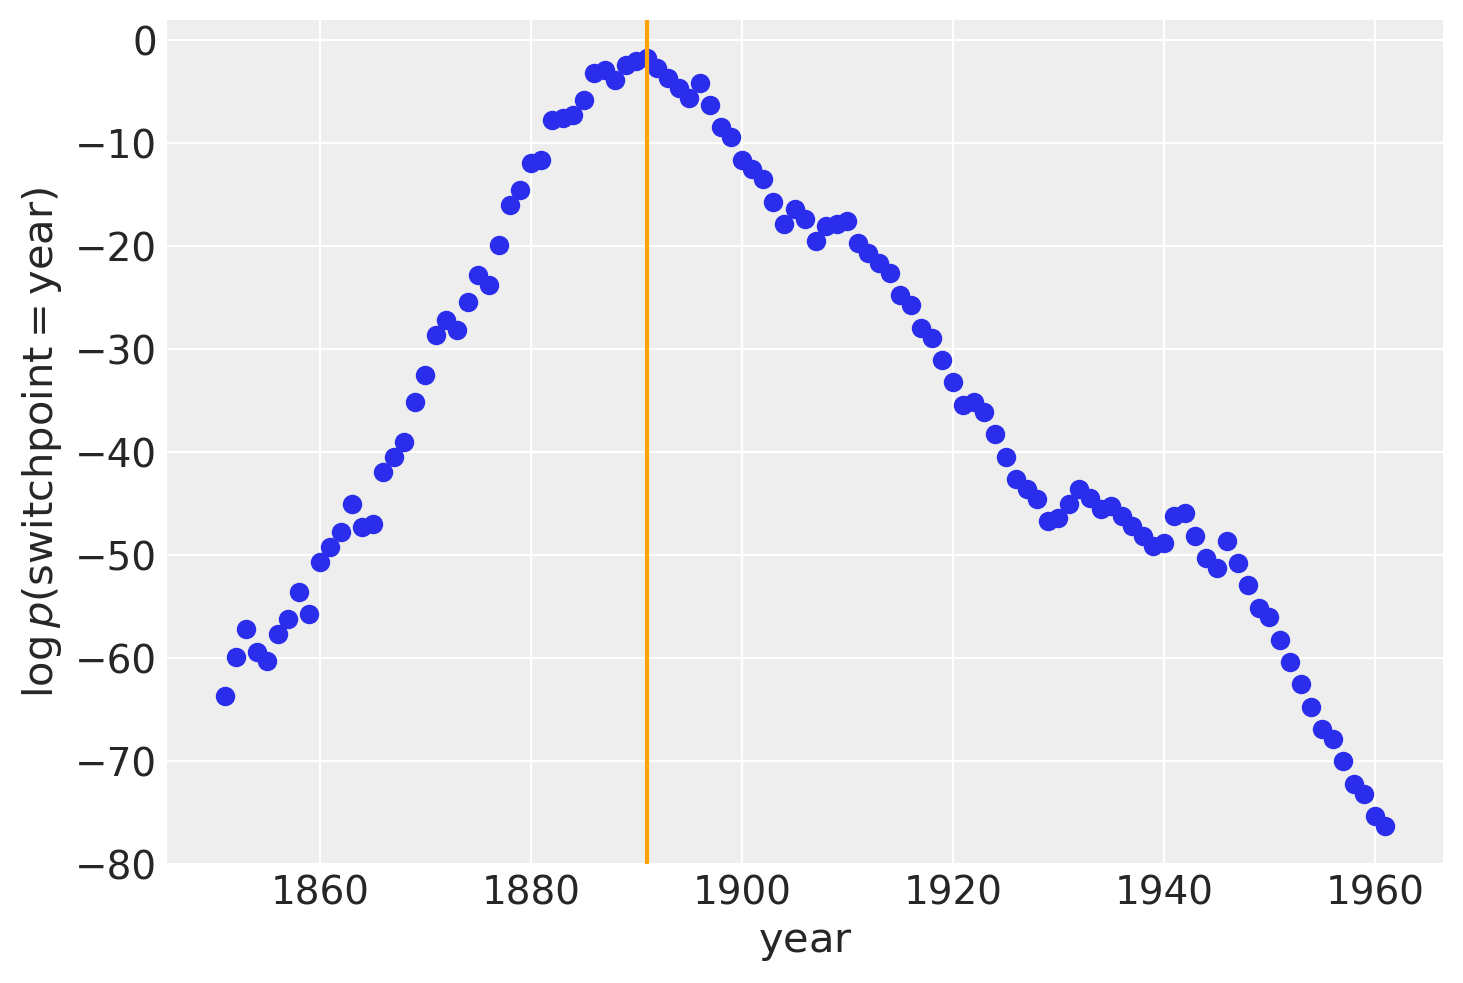

In [21]:
lp_switchpoint = after_marg.posterior.lp_switchpoint.mean(dim=["chain", "draw"])
x_max = years[lp_switchpoint.argmax()]

plt.scatter(years, lp_switchpoint)
plt.axvline(x=x_max, c="orange")
plt.xlabel(r"$\mathrm{year}$")
plt.ylabel(r"$\log p(\mathrm{switchpoint}=\mathrm{year})$");

By plotting a histogram of sampled values instead of working with the log-probabilities directly, we are left with noisier and more incomplete exploration of the underlying discrete distribution.

## Authors
* Authored by [Rob Zinkov](https://zinkov.com) in January, 2024

## References

:::{bibliography}
:filter: docname in docnames 
:::

* [STAN manual section on marginalization](https://mc-stan.org/docs/stan-users-guide/latent-discrete.html)

## Watermark

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Sat Dec 14 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

pytensor: 2.26.4
xarray  : 2024.7.0

pytensor   : 2.26.4
arviz      : 0.19.0
numpy      : 1.26.4
pandas     : 2.2.2
matplotlib : 3.9.2
pymc_extras: 0.2.0
pymc       : 5.19.1

Watermark: 2.5.0



:::{include} ../page_footer.md
:::